In [ ]:
!pip install scikit-learn

Installing packages...
Device: cpu

Loading LFW dataset...
✓ Dataset loaded: 1288 images of 7 people
Using subset: 1000 images to save RAM
Converted to PyTorch format: 1000 images

Generating circular adversarial patches...
Generated 100 circular patches

Creating dataset...
Train: 800 | Test: 200

Defining model...
Parameters: 25,730

Training detector...
Epoch  1 | Train: 63.38% | Test: 91.00%
Epoch  2 | Train: 96.00% | Test: 97.50%
Epoch  3 | Train: 99.25% | Test: 99.00%
Epoch  4 | Train: 99.75% | Test: 100.00%
Epoch  5 | Train: 100.00% | Test: 100.00%
Epoch  6 | Train: 100.00% | Test: 100.00%
Epoch  7 | Train: 99.38% | Test: 100.00%
Epoch  8 | Train: 100.00% | Test: 100.00%
Epoch  9 | Train: 100.00% | Test: 100.00%
Epoch 10 | Train: 100.00% | Test: 100.00%
Epoch 11 | Train: 100.00% | Test: 100.00%
Epoch 12 | Train: 100.00% | Test: 100.00%
Epoch 13 | Train: 100.00% | Test: 100.00%
Epoch 14 | Train: 100.00% | Test: 100.00%
Epoch 15 | Train: 100.00% | Test: 100.00%
Epoch 16 | Train: 1

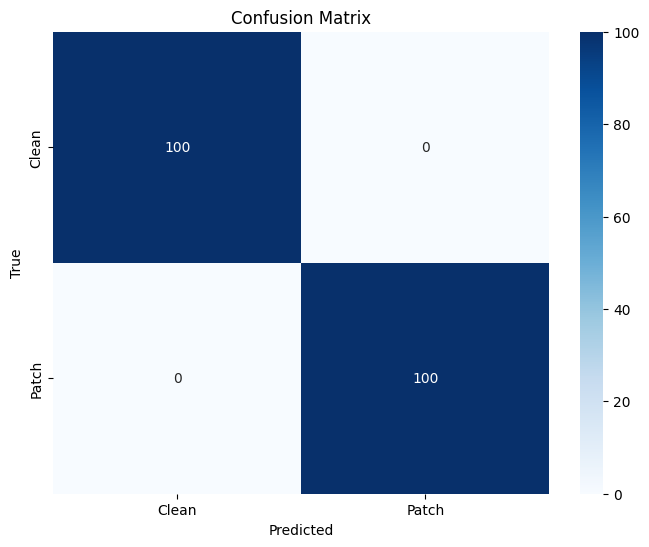

              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00       100
       Patch       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Metrics:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-Score: 100.00%

Visualizing predictions...


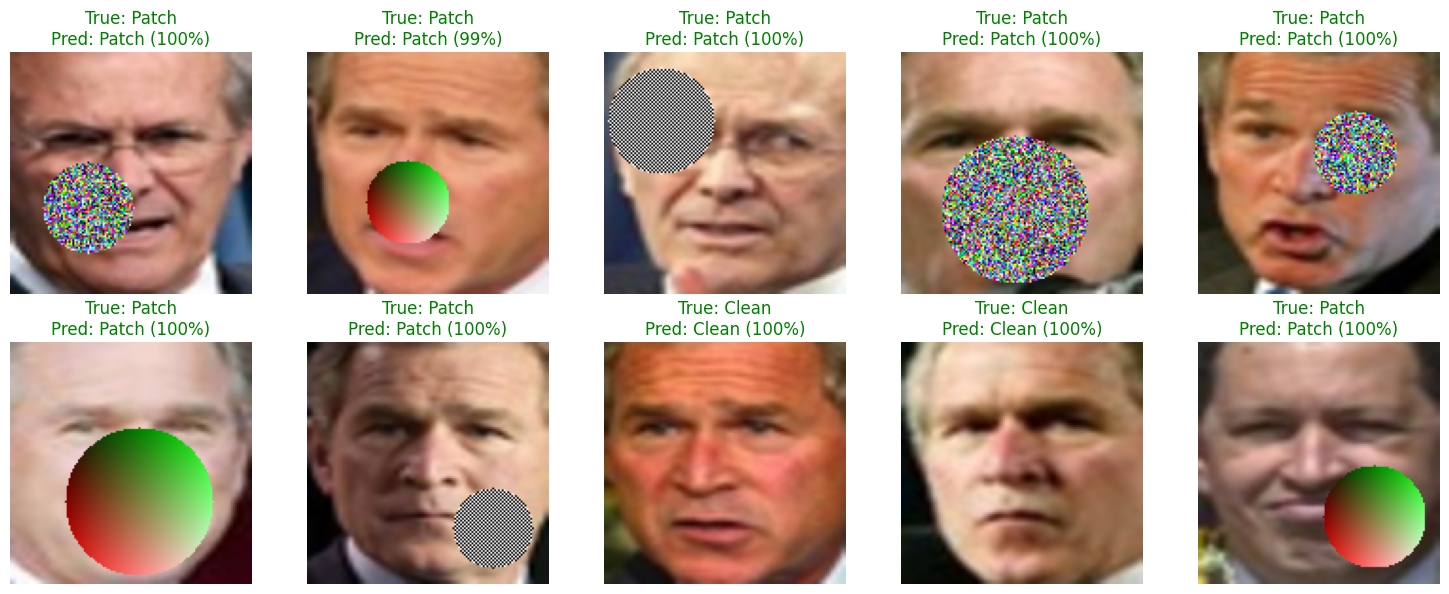


✅ STRATEGY 1 COMPLETE - Patch Detector trained!
Final accuracy: 100.00%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import CelebA# ============================================================
# ADVERSARIAL PATCH DEFENSE - COMPLETE IMPLEMENTATION

# CELL 1: SETUP
print("Installing packages...")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import LFWPeople
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# CELL 2: LOAD DATASET (Same as attack code!)
print("\nLoading LFW dataset...")
# Use min_faces_per_person to reduce dataset size and save RAM
lfw = fetch_lfw_people(color=True, resize=0.5, min_faces_per_person=70)
imgs = lfw.images          # (N,H,W,3), float64
targets = lfw.target       # integer labels
n_samples = imgs.shape[0]
target_names = lfw.target_names

print(f"✓ Dataset loaded: {n_samples} images of {len(target_names)} people")

# Use only a subset to save RAM (1000 images max)
max_images = 1000
if n_samples > max_images:
    indices = np.random.choice(n_samples, max_images, replace=False)
    imgs = imgs[indices]
    targets = targets[indices]
    n_samples = max_images
    print(f"Using subset: {n_samples} images to save RAM")

# Convert to PyTorch format
# sklearn gives us (N, H, W, 3) in [0, 1] range
# PyTorch wants (N, 3, H, W) tensors
class LFWDataset:
    def __init__(self, images, labels):
        # Convert from (N,H,W,3) to list of (3,H,W) tensors
        self.images = []
        self.labels = labels

        for img in images:
            # Resize to 128x128 (smaller to save RAM)
            img_pil = Image.fromarray((img * 255).astype(np.uint8))
            img_pil = img_pil.resize((128, 128))
            # Convert to tensor and normalize to [0,1]
            img_tensor = torch.from_numpy(np.array(img_pil)).float() / 255.0
            # Change from (H,W,3) to (3,H,W)
            img_tensor = img_tensor.permute(2, 0, 1)
            self.images.append(img_tensor)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

lfw_dataset = LFWDataset(imgs, targets)
print(f"Converted to PyTorch format: {len(lfw_dataset)} images")

# CELL 3: GENERATE CIRCULAR ADVERSARIAL PATCHES (Like attack!)
print("\nGenerating circular adversarial patches...")

def create_circular_mask(size):
    """Create a circular mask like in the attack code"""
    center = size // 2
    y, x = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((x - center)**2 + (y - center)**2)
    mask = dist_from_center <= (size // 2)
    return torch.from_numpy(mask).float()

def generate_patch(size=50, pattern='random'):
    """Generate patch with circular mask"""
    # Create circular mask
    mask = create_circular_mask(size)

    # Generate pattern
    if pattern == 'random':
        patch = torch.rand(3, size, size)
    elif pattern == 'noise':
        p = torch.randn(3, size, size) * 0.5 + 0.5
        patch = torch.clamp(p, 0, 1)
    elif pattern == 'gradient':
        x = torch.linspace(0, 1, size)
        y = torch.linspace(0, 1, size)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        patch = torch.stack([xx, yy, xx*yy])
    else:  # checkerboard
        checker = torch.zeros(size, size)
        checker[::2, ::2] = 1
        checker[1::2, 1::2] = 1
        patch = checker.unsqueeze(0).repeat(3, 1, 1)

    # Apply circular mask (make non-circle areas transparent/white)
    for c in range(3):
        patch[c] = patch[c] * mask + (1 - mask)  # White background outside circle

    return patch, mask

patches = []
masks = []
for pattern in ['random', 'noise', 'gradient', 'checkerboard']:
    for _ in range(25):
        size = random.randint(40, 80)
        patch, mask = generate_patch(size, pattern)
        patches.append(patch)
        masks.append(mask)

print(f'Generated {len(patches)} circular patches')

# CELL 4: CREATE DATASET
print("\nCreating dataset...")

class PatchDataset(Dataset):
    def __init__(self, base_dataset, patches, num_samples=5000):
        self.base_dataset = base_dataset
        self.patches = patches
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_idx = random.randint(0, len(self.base_dataset) - 1)
        image, _ = self.base_dataset[base_idx]

        # 50% chance add patch
        if random.random() < 0.5:
            patch_idx = random.randint(0, len(self.patches) - 1)
            patch = self.patches[patch_idx]
            mask = masks[patch_idx]  # Get corresponding mask

            img = image.clone()
            _, img_h, img_w = img.shape
            _, patch_h, patch_w = patch.shape

            x = random.randint(0, img_w - patch_w)
            y = random.randint(0, img_h - patch_h)

            # Apply circular patch with mask
            for c in range(3):
                img[c, y:y+patch_h, x:x+patch_w] = (
                    patch[c] * mask +
                    img[c, y:y+patch_h, x:x+patch_w] * (1 - mask)
                )

            return img, 1  # has patch
        else:
            return image, 0  # clean

train_data = PatchDataset(lfw_dataset, patches, 800)  # Smaller dataset
test_data = PatchDataset(lfw_dataset, patches, 200)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # Smaller batch
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f'Train: {len(train_data)} | Test: {len(test_data)}')

# CELL 5: DEFINE MODEL
print("\nDefining model...")

class PatchDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # Smaller model to save RAM
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 32), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = PatchDetector().to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

# CELL 6: TRAIN
print("\nTraining detector...")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0
for epoch in range(20):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (pred == labels).sum().item()

    # Test
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (pred == labels).sum().item()

    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'best_detector.pth')

    print(f'Epoch {epoch+1:2d} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%')

print(f'\nBest Accuracy: {best_acc:.2f}%')

# CELL 7: EVALUATE
print("\nEvaluating...")

model.load_state_dict(torch.load('best_detector.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, pred = torch.max(outputs, 1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clean', 'Patch'],
            yticklabels=['Clean', 'Patch'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

print(classification_report(all_labels, all_preds, target_names=['Clean', 'Patch']))

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f'\nMetrics:')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')

# CELL 8: VISUALIZE PREDICTIONS
print("\nVisualizing predictions...")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img, true_label = test_data[random.randint(0, len(test_data)-1)]

    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        prob = torch.softmax(output, dim=1)
        pred_label = torch.argmax(prob, dim=1).item()
        conf = prob[0, pred_label].item()

    ax.imshow(img.permute(1, 2, 0))
    true_str = 'Patch' if true_label == 1 else 'Clean'
    pred_str = 'Patch' if pred_label == 1 else 'Clean'
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_str}\nPred: {pred_str} ({conf*100:.0f}%)', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ STRATEGY 1 COMPLETE - Patch Detector trained!")
print(f"Final accuracy: {best_acc:.2f}%")